In [12]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16

from tensorflow.keras.applications.vgg16 import preprocess_input


import pandas as pd
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import os
import itertools
import random
import tensorflow as tf
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

# Define the custom layer Patches before loading the model
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

image_size = 224
labels = ('real', 'fake')

def get_data(data_dir, TorT):
    data = []
    
    for label in labels:
        count = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            count = count + 1
            if(TorT=="train"):
                if(count==8000):
                  break
            elif(TorT=="test"):
                if(count==200):
                  break
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype='object')

train = get_data("real-vs-fake/train/","train")
test = get_data("real-vs-fake/test/","test")

np.random.shuffle(train)
np.random.shuffle(test)

print(train.shape)
print(test.shape)

(180, 2)
(120, 2)


In [13]:
l = []
for i in train:
    if i[1] == 0:
        l.append('real')
    else:
        l.append('fake')

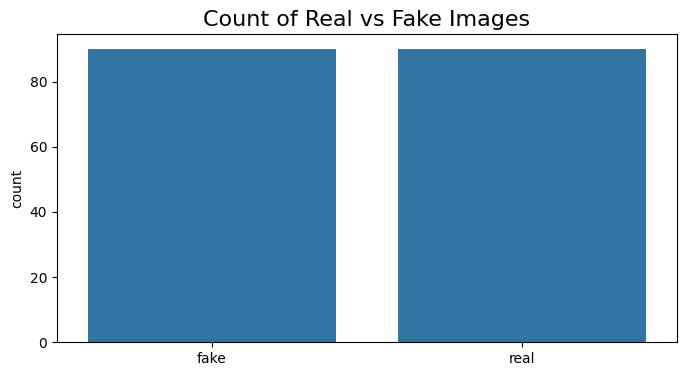

In [14]:
plt.figure(figsize=(8, 4))
plt.title('Count of Real vs Fake Images', size=16)
sns.countplot(x=l)
plt.show()

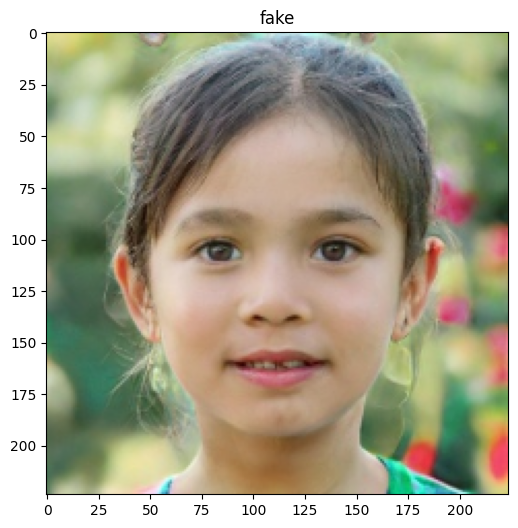

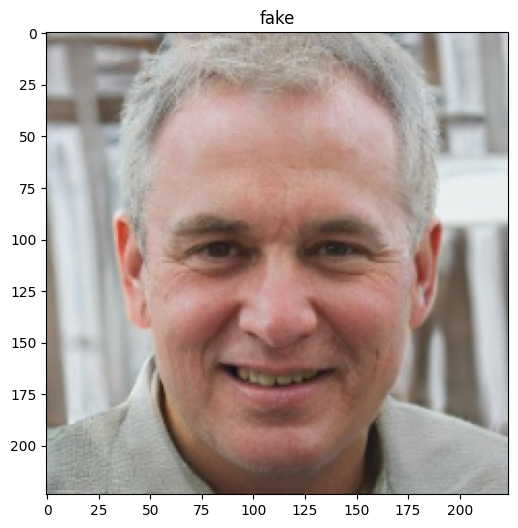

In [15]:
# randomly visualizing images to see what's going on
plt.figure(figsize=(8, 6))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])
plt.show()

X_train = []
X_test = []
y_train = []
y_test = []

In [16]:
# dividing data into train and test sets
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [17]:
# Normalise the image data (to convert it to range from 0 to 1)
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(180, 224, 224, 3)
(120, 224, 224, 3)
(180,)
(120,)


In [18]:
import tensorflow_addons as tfa 

num_classes = 2
input_shape = (224, 224, 3)    
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 80
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

c:\Users\harsh\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


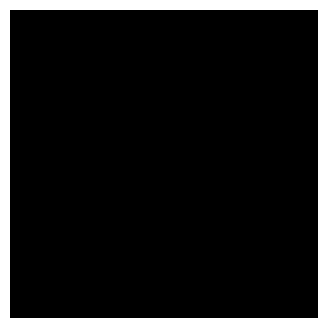

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

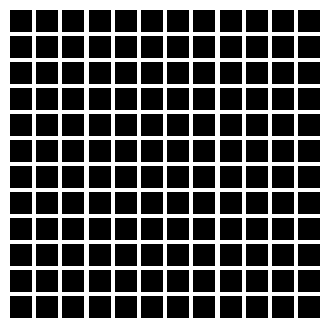

In [20]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded    


In [21]:

def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


Epoch 1/80
1/1 [==============================] - 26s 26s/step - loss: 1.6906 - accuracy: 0.4938 - top-5-accuracy: 1.0000 - val_loss: 13.1961 - val_accuracy: 0.5556 - val_top-5-accuracy: 1.0000
Epoch 2/80
1/1 [==============================] - 9s 9s/step - loss: 14.7158 - accuracy: 0.4938 - top-5-accuracy: 1.0000 - val_loss: 4.7877 - val_accuracy: 0.4444 - val_top-5-accuracy: 1.0000
Epoch 3/80
1/1 [==============================] - 8s 8s/step - loss: 3.6223 - accuracy: 0.5617 - top-5-accuracy: 1.0000 - val_loss: 0.9246 - val_accuracy: 0.6111 - val_top-5-accuracy: 1.0000
Epoch 4/80
1/1 [==============================] - 8s 8s/step - loss: 1.3371 - accuracy: 0.6358 - top-5-accuracy: 1.0000 - val_loss: 2.9494 - val_accuracy: 0.5556 - val_top-5-accuracy: 1.0000
Epoch 5/80
1/1 [==============================] - 8s 8s/step - loss: 3.2271 - accuracy: 0.5123 - top-5-accuracy: 1.0000 - val_loss: 1.1106 - val_accuracy: 0.4444 - val_top-5-accuracy: 1.0000
Epoch 6/80
1/1 [=========================

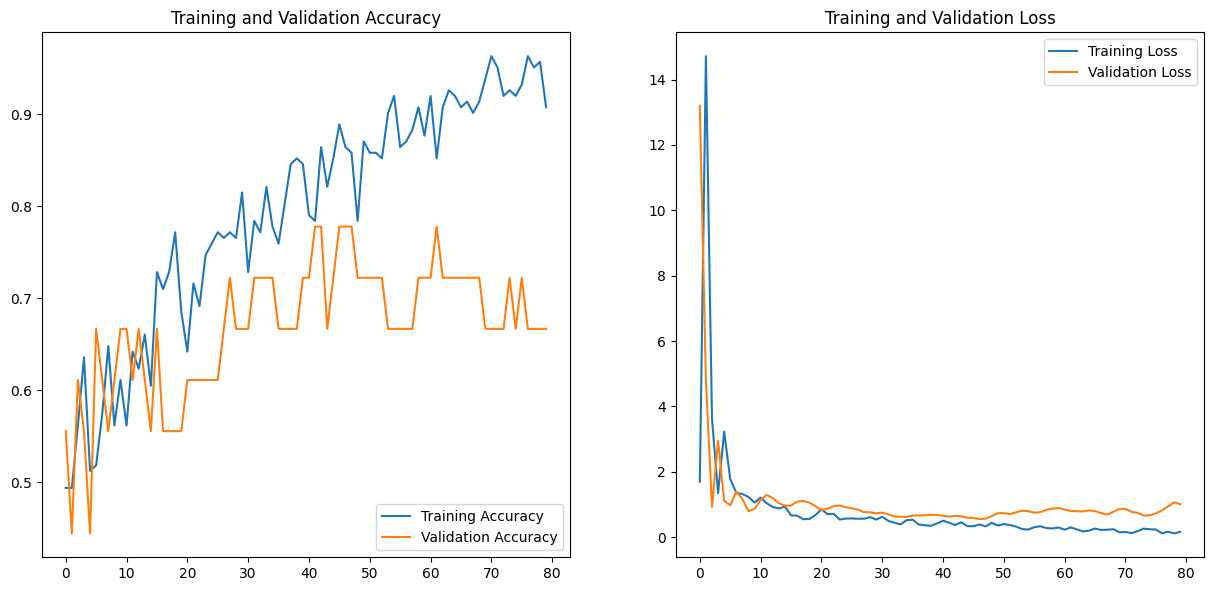

Confusion Matrix:
[[0.57142857 0.47058824]
 [0.42857143 0.52941176]]


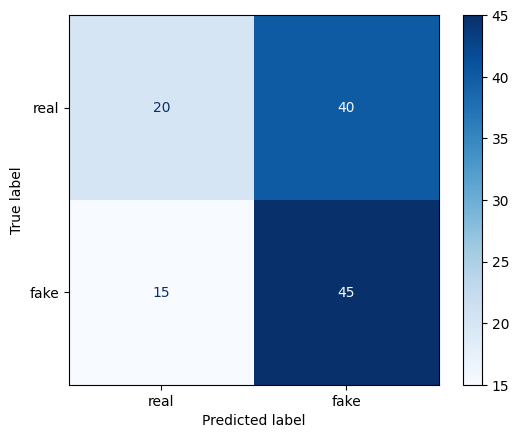

In [22]:

vit_classifier = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

vit_classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = vit_classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
)

predictions = np.argmax(vit_classifier.predict(X_test), axis=-1)

print("Classification Report:")
print(classification_report(y_test, predictions, target_names=['real', 'fake']))
print("Accuracy:", metrics.accuracy_score(y_test, predictions) * 100)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# building the confusion matrix
result = confusion_matrix(y_test, predictions, normalize='pred')
print("Confusion Matrix:")
print(result)

labels = ["real", "fake"]
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
vit_classifier.save(os.path.join('models', 'mymodel.h5'))

c:\Users\harsh\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [78]:
# Define VGG-16 prediction function
def vgg_predict(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)  # Preprocess input image
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    return np.argmax(predictions)


# Define ensemble prediction function
def ensemble_predict(img_path, models):
    predictions = []
    for model in models:
        if model == vgg_model:
            pred = vgg_predict(img_path, model)
        else:
            img = cv2.imread(img_path)
            resize = tf.image.resize(img, (224, 224))
            pred = np.argmax(model.predict(np.expand_dims(resize, 0)), axis=-1)
        predictions.append(pred)
    # Perform majority voting
    combined_pred = np.round(np.mean(predictions, axis=0))
    return combined_pred

In [87]:
def ensemble_predict(img_path, models):
    predictions = []
    for model in models:
        if model == vgg_model:
            pred = vgg_predict(img_path, model)
        else:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            img = img / 255.0  # Normalize the image
            pred = np.argmax(model.predict(np.expand_dims(img, 0)), axis=-1)
            pred = np.squeeze(pred)  # Ensure predictions have the same shape
        predictions.append(pred)
    
    print("Individual predictions:", predictions)
    
    # Perform majority voting
    combined_pred = np.round(np.mean(predictions, axis=0))
    return int(combined_pred)  # Return the combined prediction as an integer




In [118]:
# Make predictions using the ensemble of models
image_path = r'C:\Users\harsh\OneDrive\Desktop\new BE\fakeee.jpeg'
ensemble_prediction = ensemble_predict(image_path, [vit_classifier])

# Print the combined prediction
print("Ensemble Prediction:", ensemble_prediction)

1/1 [==============================] - 0s 58ms/step
Individual predictions: [array(0, dtype=int64)]
Ensemble Prediction: 0
